# Rating-based Approach

Please change all file directories to your own local directories

In [ ]:
import pandas as pd 
import numpy as np 
import csv
from tqdm import tqdm
from collections import Counter

!pip install stargazer
import statsmodels.api as sm
from stargazer.stargazer import Stargazer

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !python3 --version

Python 3.8.5


In [ ]:
# pip list

Package                            Version
---------------------------------- -------------------
absl-py                            1.0.0
affine                             2.3.0
aiohttp                            3.8.1
aiosignal                          1.2.0
alabaster                          0.7.12
ale-py                             0.7.3
anaconda-client                    1.9.0
anaconda-navigator                 2.1.0
anaconda-project                   0.10.2
anyio                              2.2.0
appdirs                            1.4.4
applaunchservices                  0.2.1
appnope                            0.1.2
appscript                          1.1.2
argh                               0.26.2
argon2-cffi                        20.1.0
arrow                              1.2.1
asgiref                            3.5.0
asn1crypto                         1.4.0
astroid                            2.6.6
astropy                            5.0
astunparse                         1.6.

Note: you may need to restart the kernel to use updated packages.


## Load dataset

In [ ]:
comments = pd.read_csv('/content/drive/MyDrive/Dataset/moviedata-10m/comments.csv')
comments.columns

Index(['COMMENT_ID', 'USER_MD5', 'MOVIE_ID', 'CONTENT', 'VOTES',
       'COMMENT_TIME', 'RATING'],
      dtype='object')

In [ ]:
comments = comments.loc[:, ['COMMENT_TIME','COMMENT_ID','MOVIE_ID', 'USER_MD5','CONTENT', 'VOTES', 'RATING']]
comments = comments.rename(columns={'COMMENT_ID':'comment_id',
                                    'COMMENT_TIME':'comment_time',
                                    'MOVIE_ID':'movie_id',
                                    'RATING':'rating',
                                    'CONTENT':'content',
                                   'USER_MD5':'user_md5',
                                   'VOTES':'votes'})
comments.head()

,comment_time,comment_id,movie_id,user_md5,content,votes,rating
0,2018-09-05 19:42:07,1359352573,5113101,0ab7e3efacd56983f16503572d2b9915,480p，画质不高，黑白，y,0,2.0
1,2019-07-09 14:52:07,1598245094,5113101,84dfd3f91dd85ea105bc74a4f0d7a067,毫无看点，黑白画质，一个男人孤独的心理情景历程，疯疯癫癫，没有任何恐怖的成分，这应该是剧情片吧.,0,1.0
2,2010-11-05 22:15:44,311937819,3718526,c9a47fd59b55967ceac07cac6d5f270c,上吊那裡超好笑，可惜最後報告近況的旁白大扣分,0,3.0
3,2010-06-20 02:12:50,262536568,3718526,35d3d5a52a7515c2ca6bb4d8e965149b,上海国际电影节观摩片,0,NaN
4,2011-04-09 22:10:13,376372407,3718526,54bfe88b57d8a3caea2637e62d182cf7,！,0,NaN


### Check  duplication and empty comments 

In [ ]:
len(set(comments['comment_id'])) == len(comments)

True

In [ ]:
# check empty content
empty_lst = []
error_lst = []
for index, row in tqdm(comments.iterrows()):
    try:
        if not row['content'].strip():
            empty_lst.append(index)
    except AttributeError:
        error_lst.append(index)

4428475it [03:31, 20917.18it/s]


In [ ]:
empty_lst, error_lst

([190275,
  214925,
  396835,
  1537748,
  1922925,
  2146103,
  2583066,
  3101326,
  3770463],
 [2065335, 2875690])

In [ ]:
comments.drop(empty_lst + error_lst, axis=0, inplace=True)
comments = comments.reset_index(drop=True)
comments

,comment_time,comment_id,movie_id,user_md5,content,votes,rating
0,2018-09-05 19:42:07,1359352573,5113101,0ab7e3efacd56983f16503572d2b9915,480p，画质不高，黑白，y,0,2.0
1,2019-07-09 14:52:07,1598245094,5113101,84dfd3f91dd85ea105bc74a4f0d7a067,毫无看点，黑白画质，一个男人孤独的心理情景历程，疯疯癫癫，没有任何恐怖的成分，这应该是剧情片吧.,0,1.0
2,2010-11-05 22:15:44,311937819,3718526,c9a47fd59b55967ceac07cac6d5f270c,上吊那裡超好笑，可惜最後報告近況的旁白大扣分,0,3.0
3,2010-06-20 02:12:50,262536568,3718526,35d3d5a52a7515c2ca6bb4d8e965149b,上海国际电影节观摩片,0,NaN
4,2011-04-09 22:10:13,376372407,3718526,54bfe88b57d8a3caea2637e62d182cf7,！,0,NaN
...,...,...,...,...,...,...,...
4428459,2018-07-08 17:48:09,1402192514,26914297,517cd1ba10c6bf42465184808ec80c1f,歌舞精良，但是故事情节看的真是闹心。在时代的大背景下，谁都无法独善其身。,0,5.0
4428460,2017-01-03 17:55:35,1131394883,26914297,9b03a9f6953b06611e3352a889ecdfa2,麦金托什的25周年全部是视觉路线,0,4.0
4428461,2018-12-10 20:09:20,1565118781,26914297,4f696ad30cec6601ca49dfc2281985f3,记不住里面任何一首歌，就觉得胖女孩的胳膊记忆犹新,0,3.0
4428462,2019-08-03 14:39:02,1888955067,26914297,9b32c4b5f73092083e23669ea6731b86,故事不喜欢，但是场景精致，唱段好听。,0,4.0


In [ ]:
comments['comment_time'] = pd.to_datetime(comments['comment_time'])
comments = comments.set_index('comment_time').sort_index()
comments_count = comments['content'].groupby(comments.index.year).count().tolist()                     
comments_count

[1603,
 13596,
 34985,
 92789,
 142996,
 261817,
 355512,
 377018,
 312147,
 270202,
 268842,
 344790,
 453415,
 563922,
 934830]

In [ ]:
comments_count_df = pd.DataFrame(comments['content'].groupby(comments.index.year).count(), columns=['content'])  

### Check information

#### Number of comments by year

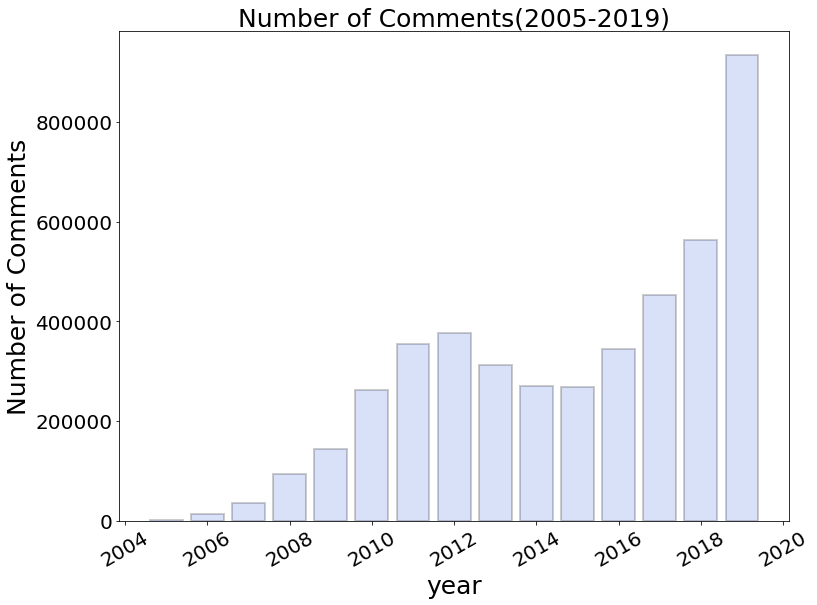

In [ ]:
# plot number of comments by year
fig, ax = plt.subplots()
fig.set_size_inches(12, 9)
plt.bar(x = comments_count_df.index, 
        height = comments_count_df['content'], 
        width = 0.8, 
        edgecolor = 'black', 
        linewidth = 2, 
        align = 'center', 
        color = 'royalblue',
        alpha=0.2,
        yerr = 0.5, 
        ecolor = 'r')
plt.title('Number of Comments(2005-2019)',fontsize=25)
plt.ylabel('Number of Comments', fontsize=25)
plt.xlabel('year', fontsize=25)
plt.xticks(rotation=30, fontsize=20)
plt.yticks(fontsize=20)

plt.savefig('/content/drive/MyDrive/Colab Notebooks/30200_analysis/results_rating/num_comments_2005_2019.png')

#### movie distribution

In [ ]:
movie_ids = set(comments['movie_id'])
len(movie_ids)

68887

In [ ]:
movies_df = pd.read_csv('/content/drive/MyDrive/Dataset/moviedata-10m/movies.csv')
movies_df = movies_df.rename(columns={'MOVIE_ID':'movie_id',
                                    'YEAR':'year'})
movies_df

,movie_id,NAME,ALIAS,ACTORS,COVER,DIRECTORS,DOUBAN_SCORE,DOUBAN_VOTES,GENRES,IMDB_ID,...,MINS,OFFICIAL_SITE,REGIONS,RELEASE_DATE,SLUG,STORYLINE,TAGS,year,ACTOR_IDS,DIRECTOR_IDS
0,26670818,情定河州,情定临夏天使然,王博/吴佳尼/王姬/高丽雯/郭力行/尹哲/沈丹萍/罗中旭/臧金生/罗刚/居文沛/阎青妤,NaN,尹哲,0.0,0.0,剧情/爱情,NaN,...,0.0,NaN,中国大陆,NaN,RmNQQeyzb,电影《情定临夏天使然》讲述临夏新一代青年人发奋图强、借助国家一带一路战略励志创业的故事。,甘肃/临夏/伊斯兰/中国/2016/中国大陆/烂片/宣传伊斯兰教的电影,2049.0,王博:|吴佳尼:1313262|王姬:1275275|高丽雯:1325661|郭力行:135...,尹哲:1326188
1,25815002,我不是李小龙,NaN,谷尚蔚/吴孟达/曾志伟/杜海涛,NaN,洪金宝,0.0,0.0,动作/爱情,NaN,...,0.0,NaN,中国大陆,NaN,EZnVfiNYf,桀骜不驯的如龙武功高强，在一场比赛中，被打成重伤，被诊今生不能再用功夫。女友荆兰为激发他重新...,穿越/华语,2049.0,谷尚蔚:1330813|吴孟达:1016771|曾志伟:1002862|杜海涛:1313024,洪金宝:1055887
2,26392287,曼哈顿中国女孩,NaN,NaN,NaN,NaN,0.0,0.0,剧情,NaN,...,0.0,NaN,中国大陆 / 美国,NaN,NuUvEJnzb,平民女孩李莉只身初入曼哈顿求学，在历经迷失与困惑之后，凭借努力与善良收获了事业上的成功，同时...,NaN,2049.0,NaN,NaN
3,26695995,绿毛水怪,NaN,NaN,NaN,梁栋/吴国墉,0.0,0.0,爱情,NaN,...,0.0,NaN,中国大陆,NaN,rqaqyb6ea,王小波经典中篇小说《绿毛水怪》将改编电影。《绿毛水怪》是王小波早期手稿作品，以天马行空的想象...,小波/王小波/爱情/小说改编/文学改编/剧情/中国/2017,2049.0,NaN,梁栋:|吴国墉:
4,26392292,为了祖国,NaN,NaN,NaN,NaN,0.0,0.0,剧情/历史,NaN,...,0.0,NaN,中国大陆 / 韩国,NaN,Inrqy7uib,1932年上海虹口爆炸案后，韩国国父金九在褚辅成、朱爱宝这些普通群众的帮助下逃到嘉兴避难。金...,NaN,2049.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140497,5108106,Pretty Boy and Rosa - 电影,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,...,0.0,NaN,NaN,NaN,nN2zjz7Yf,NaN,NaN,0.0,NaN,NaN
140498,5108082,番茄杀手 - 电影,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,...,0.0,NaN,NaN,NaN,N2jjNYnVf,NaN,NaN,0.0,NaN,NaN
140499,5108078,Fast Track - 电影,NaN,基思·卡拉丹/弗雷德·威廉森/邓肯·雷格尔/布兰迪·莱德福特/塞巴斯蒂安·斯宾赛/罗伯特·卡...,NaN,T·J·斯科特,0.0,0.0,剧情/动作,tt0124239,...,60.0,NaN,美国,NaN,AIBeyzzVf,NaN,NaN,1997.0,NaN,NaN
140500,5108060,7-9-13 - 电影,NaN,NaN,NaN,NaN,0.0,0.0,喜剧,tt0124270,...,0.0,NaN,丹麦,NaN,EJ3zzbERe,NaN,NaN,1934.0,NaN,NaN


In [ ]:
movie_year_dic = {}
for idx, row in tqdm(movies_df.iterrows()):
  movie_year_dic[row['movie_id']] = row['year']

140502it [00:10, 13334.63it/s]


In [ ]:
missing_movies = set()
movie_rating_year_dic = {}
for idx, row in tqdm(comments.iterrows()):
  if row['movie_id'] in movie_year_dic:
    if row['movie_id'] not in movie_rating_year_dic:
      movie_rating_year_dic[row['movie_id']] = [[], 0]
      movie_rating_year_dic[row['movie_id']][1] = movie_year_dic[row['movie_id']]
    movie_rating_year_dic[row['movie_id']][0].append(row['rating']) 
  else:
    missing_movies.add(row['movie_id'])
'miss {} movies'.format(len(missing_movies))

4428464it [06:22, 11582.43it/s]


'miss 19 movies'

In [ ]:
movie_idx = []
rating = []
year = []
for movie, v in movie_rating_year_dic.items():
  movie_idx.append(movie)
  rating.append(np.nanmean(v[0]))
  year.append(v[1])

movie_info = {
    'movie_id':movie_idx,
    'movie_rating':rating,
    'release_year': year
}
df_movie_info = pd.DataFrame(movie_info)
nan_rating_mask = df_movie_info['movie_rating'].isnull()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


In [ ]:
year_mask = (df_movie_info['release_year'] >= 2005) & (df_movie_info['release_year'] <= 2019)

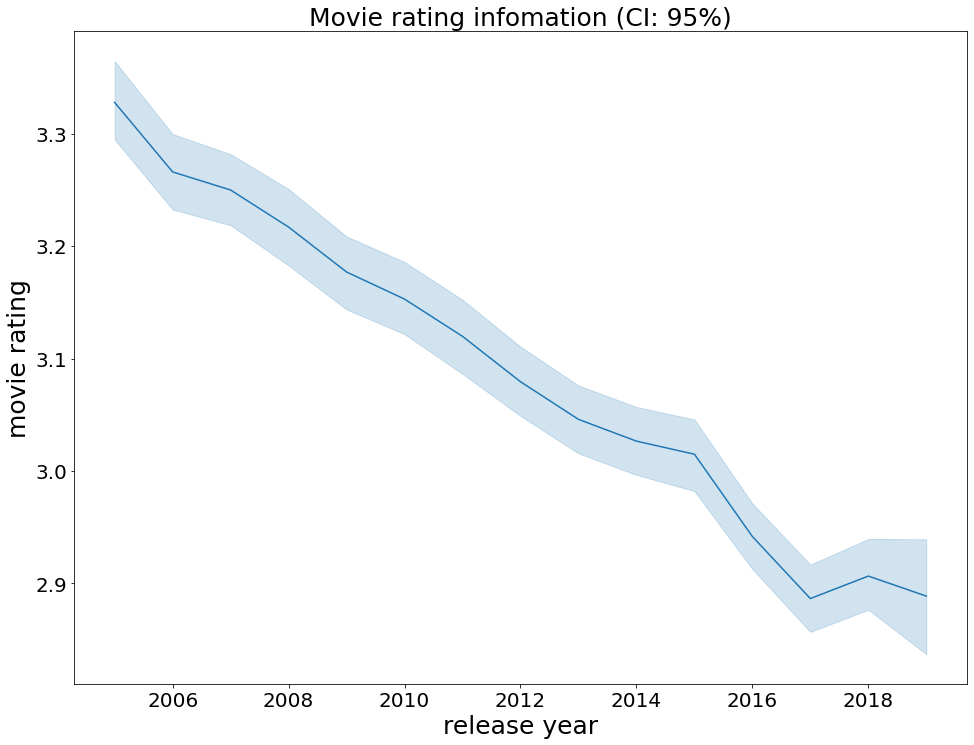

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 12)
sns.lineplot(x='release_year', 
            y='movie_rating', 
            data=df_movie_info[~nan_rating_mask & year_mask],
            ci=95)
plt.title("Movie rating infomation (CI: 95%)",fontsize=25)
plt.ylabel('movie rating', fontsize=25)
plt.xlabel('release year',fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# plt.legend(loc='upper right')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/30200_analysis/results_rating/movie_rating_info(2005-2019).png')

### Get some other inforamtion

In [ ]:
def get_rating_by_year(comments, comments_count):
    
    cur = 0
    year = 2005
    dic = {}
    total_users_dic = {}
    for year_num in comments_count:
        rating_1 = 0
        rating_2 = 0
        rating_3 = 0
        rating_4 = 0
        rating_5 = 0
        rating_nan = 0
        
        # comments with ratings 
        score_lst = []
        users_dic = {}
        for x, md5 in tqdm(zip(comments.iloc[cur: cur + year_num]['rating'], 
                          comments.iloc[cur: cur + year_num]['user_md5'])):
            # users_info in one year
            if md5 not in users_dic:
                users_dic[md5] = 0
            users_dic[md5] += 1
            
            # all users_info
            if md5 not in total_users_dic:
                total_users_dic[md5] = 0
            total_users_dic[md5] += 1
            
            
            if x in set((1.0,)):
                rating_1 += 1
                score_lst.append(x)
            elif x in set((2.0,)):
                rating_2 += 1
                score_lst.append(x)
            elif x in set((3.0,)):
                rating_3 += 1
                score_lst.append(x)
            elif x in set((4.0,)):
                rating_4 += 1
                score_lst.append(x)
            elif x in set((5.0,)):
                rating_5 += 1
                score_lst.append(x)
            else:
                rating_nan += 1
        
        # cal proportion
        portion_1 = rating_1/year_num
        portion_2 = rating_2/year_num
        portion_3 = rating_3/year_num
        portion_4 = rating_4/year_num
        portion_5 = rating_5/year_num
        portion_nan = rating_nan/year_num
        
        # cal mean and std of ratings
        rating_mean = np.array(score_lst).mean()
        rating_std = np.array(score_lst).std()
        
        # user stats
        user_num = len(users_dic.values())
        user_avg_comments = np.array(list(users_dic.values())).mean()
        user_std_comments = np.array(list(users_dic.values())).std()
        
        dic[year] = [rating_1, rating_2, rating_3, rating_4, rating_5, rating_nan,
                    portion_1, portion_2, portion_3, portion_4, portion_5, portion_nan,
                    rating_mean, rating_std, user_num, user_avg_comments, user_std_comments]
        cur += year_num
        year += 1
    return dic, total_users_dic

In [ ]:
dic, user_dic = get_rating_by_year(comments, comments_count)

1603it [00:00, 355231.64it/s]
13596it [00:00, 361879.89it/s]
34985it [00:00, 356177.68it/s]
92789it [00:00, 354146.71it/s]
142996it [00:00, 351117.48it/s]
261817it [00:00, 337500.56it/s]
355512it [00:01, 337784.21it/s]
377018it [00:01, 311933.37it/s]
312147it [00:00, 325382.21it/s]
270202it [00:00, 319919.48it/s]
268842it [00:00, 340608.46it/s]
344790it [00:01, 332999.93it/s]
453415it [00:01, 332717.45it/s]
563922it [00:01, 335041.07it/s]
934830it [00:02, 319455.93it/s]


In [ ]:
s = 0
for v in dic.values():
    s += sum(v[:6])
s

4428464

In [ ]:
sum(comments_count)

4428464

In [ ]:
df = pd.DataFrame(dic, index = ['rating=1.0','rating=2.0', 'rating=3.0', 'rating=4.0', 'rating=5.0', 'rating=NaN',
                               'portion_1.0','portion_2.0', 'portion_3.0', 'portion_4.0', 'portion_5.0', 'portion_NaN',
                               'rating_mean', 'rating_std', 'user_num', 'user_avg_comments', 'user_std_comments'])
x = df.columns
df

,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
rating=1.0,53.000000,389.000000,1160.000000,3328.000000,6129.000000,12077.000000,20003.000000,23030.000000,24485.000000,24250.000000,25781.000000,32965.000000,40558.000000,50546.000000,53433.000000
rating=2.0,104.000000,1084.000000,2915.000000,8476.000000,14236.000000,26927.000000,39238.000000,43616.000000,39546.000000,35299.000000,37305.000000,46781.000000,61730.000000,75644.000000,96324.000000
rating=3.0,386.000000,3598.000000,9723.000000,27719.000000,44141.000000,82005.000000,114238.000000,123536.000000,101548.000000,87241.000000,88066.000000,111189.000000,145482.000000,180134.000000,283885.000000
rating=4.0,502.000000,4296.000000,10809.000000,28878.000000,44494.000000,82146.000000,108721.000000,110936.000000,84929.000000,70643.000000,67822.000000,89832.000000,121597.000000,151439.000000,298393.000000
rating=5.0,369.000000,2926.000000,6287.000000,15961.000000,22913.000000,40933.000000,50429.000000,49848.000000,40007.000000,34477.000000,32399.000000,44065.000000,59336.000000,74612.000000,166397.000000
rating=NaN,189.000000,1303.000000,4091.000000,8427.000000,11083.000000,17729.000000,22883.000000,26052.000000,21632.000000,18292.000000,17469.000000,19958.000000,24712.000000,31547.000000,36398.000000
portion_1.0,0.033063,0.028611,0.033157,0.035866,0.042861,0.046128,0.056265,0.061085,0.078441,0.089748,0.095896,0.095609,0.089450,0.089633,0.057158
portion_2.0,0.064878,0.079729,0.083321,0.091347,0.099555,0.102847,0.110370,0.115687,0.126690,0.130639,0.138762,0.135680,0.136145,0.134139,0.103039
portion_3.0,0.240799,0.264637,0.277919,0.298732,0.308687,0.313215,0.321334,0.327666,0.325321,0.322873,0.327575,0.322483,0.320858,0.319431,0.303676
portion_4.0,0.313163,0.315975,0.308961,0.311222,0.311156,0.313753,0.305815,0.294246,0.272080,0.261445,0.252275,0.260541,0.268180,0.268546,0.319195


In [ ]:
year_info = {'year':comments.index.year}
comments['year'] = year_info['year']
comments

,comment_id,movie_id,user_md5,content,votes,rating,movie_year_info,year
comment_time,,,,,,,,
2005-06-12 02:22:07,3942,1291856,4d69f002306f819034976e3818a84908,http://www.bighead.cn/?p=15,19,4.0,2003.0,2005
2005-06-12 02:22:07,3944,1291581,4d69f002306f819034976e3818a84908,平安夜跟小白看了粤语版，驴子的台词再创造得很可爱。,6,4.0,2001.0,2005
2005-06-12 02:22:07,3943,1291832,4d69f002306f819034976e3818a84908,我爱特拉沃塔的舞。,1590,5.0,1994.0,2005
2005-06-12 02:22:07,3945,1291582,4d69f002306f819034976e3818a84908,20061118跟小白重看了一遍。,0,5.0,2004.0,2005
2005-06-12 02:22:09,4104,1292210,6c0f657ba0d8600e45f323e65a8de516,重看依然很喜欢很喜欢,0,4.0,1970.0,2005
...,...,...,...,...,...,...,...,...
2019-09-07 15:57:07,1942942072,27063867,79a5045cc0cce798c046b84a56578d6d,就很尬，很无聊，笑点好无语，朱亚文为什么要接这样的片子啊………,0,2.0,2019.0,2019
2019-09-07 15:58:03,1942943180,27063867,fed2dab59d6797ad2c3838091a1288b8,吃了感冒药去看的，困上加困。朱亚文是想通过这部作品来拓宽戏路吗？,0,2.0,2019.0,2019
2019-09-07 15:58:51,1942944164,27063867,32b9368b0d6edac78eed1049434f765b,有些地方还是很好笑的，奔着两位主演去看，他们也确实有范儿，倒数第二场戏，两人穿礼服去办公室真...,0,2.0,2019.0,2019


##### Rating distribution

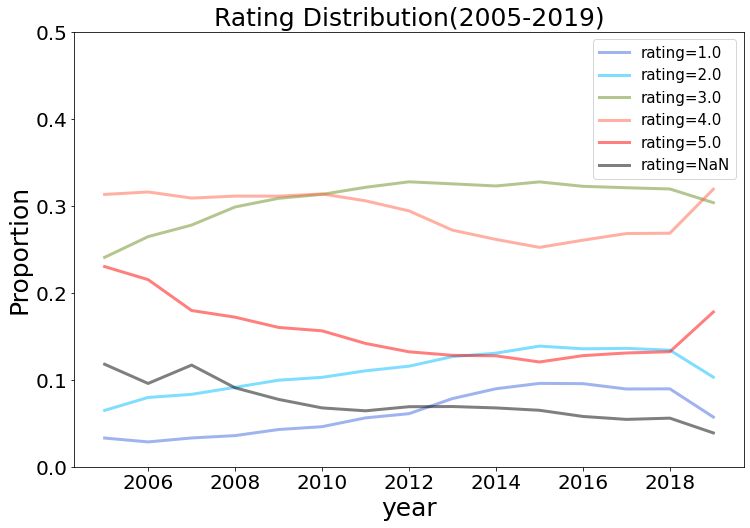

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(x, 
        df.loc['portion_1.0', :],
        c='royalblue', 
        linewidth=3,
        alpha=0.5,
        label='rating=1.0')

ax.plot(x, 
        df.loc['portion_2.0', :],
        c='deepskyblue', 
        linewidth=3,
        alpha=0.5,
        label='rating=2.0')

ax.plot(x, 
        df.loc['portion_3.0', :],
        linewidth=3,
        alpha=0.5,
        color='olivedrab', label='rating=3.0')

ax.plot(x, 
        df.loc['portion_4.0', :],
        linewidth=3,
        alpha=0.5,
        color='tomato', label='rating=4.0')

ax.plot(x, 
        df.loc['portion_5.0', :],
        linewidth=3,
        alpha=0.5,
        color='red', 
        label='rating=5.0')

ax.plot(x, 
        df.loc['portion_NaN', :],
        linewidth=3,
        alpha=0.5,
        color='k', label='rating=NaN')

plt.title("Rating Distribution(2005-2019)",fontsize=25)
plt.ylabel('Proportion',fontsize=25)
plt.ylim([0, 0.5])
plt.xlabel('year',fontsize=25)

plt.xticks(fontsize=20);
plt.yticks(fontsize=20);
plt.legend(loc = 'upper right',fontsize=15)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/30200_analysis/results_rating/rating_distribution_2005_2019.png')

##### Mean rating

In [ ]:
comments_plt = comments.reset_index()

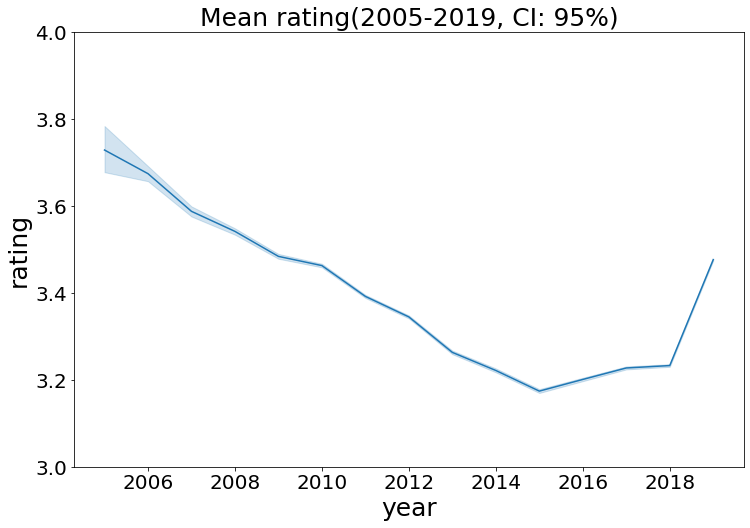

In [ ]:
# default CI: 95%
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
sns.lineplot(x="year",y="rating",
             data=comments_plt[comments_plt['rating'].isin([1.0, 2.0, 3.0, 4.0, 5.0])],
             ci=95)
plt.title("Mean rating(2005-2019, CI: 95%)",fontsize=25)
ax.set_yticks([3.0, 3.2, 3.4, 3.6, 3.8, 4.0]);
plt.ylabel('rating', fontsize=25)
plt.xlabel('year',fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/30200_analysis/results_rating/mean_rating_2005_2019.png')

##### Appeared users by year

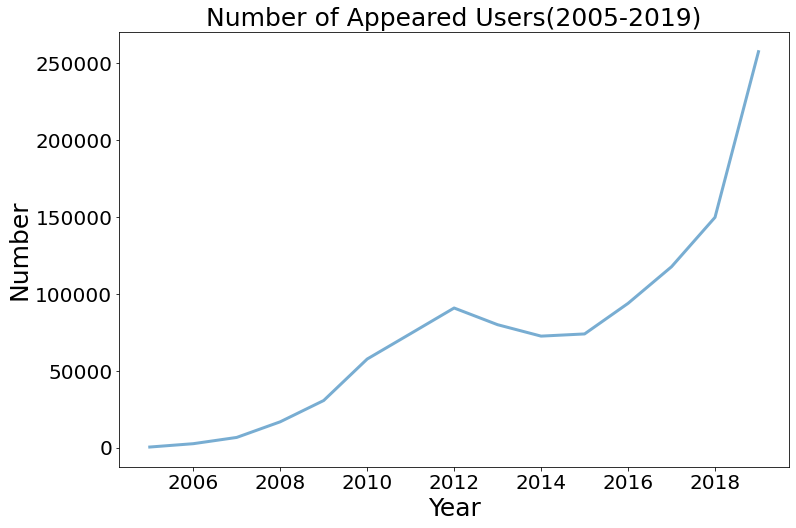

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(x, df.loc['user_num', :], label='active users', linewidth=3, alpha=0.6)
plt.title("Number of Appeared Users(2005-2019)",fontsize=25)
plt.ylabel('Number',fontsize=25)
plt.xlabel('Year',fontsize=25)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/30200_analysis/results_rating/appeared_users_2005_2019.png')

## Get finer-granularity user-level analysis

Distribution of users in using number of comments as activity level. 

### Check basic information and preparation

Here we define users having more than 22 comments appeared in our dataset as active users. 

Note:since this dataset is incompelete, those defined as less active users could also be active. Hence 22 comments could be an underestimated number. 

In [ ]:
"95 percenitle user's number of comments is %.1f"% np.percentile(list(user_dic.values()), 95)

"95 percenitle user's number of comments is 22.0"

In [ ]:
print("%i users"%len(user_dic.keys()))
print("%i comments"%sum(user_dic.values()))
print("%.3f comments per user"%(sum(user_dic.values())/len(user_dic.keys())))

638961 users
4428464 comments
6.931 comments per user


In [ ]:
comments_from_active_users = 0
count_active_user = 0
for v in user_dic.values():
    if v >= 22:
        count_active_user +=1
        comments_from_active_users += v
print('%i active users'%count_active_user)
print('%i comments from active users'%comments_from_active_users)

32464 active users
2709865 comments from active users


In [ ]:
user_comment_dic = {'users':[len(user_dic.keys()) - count_active_user, count_active_user],
                   'comments':[sum(user_dic.values())-comments_from_active_users, comments_from_active_users]}

In [ ]:
pd.DataFrame(user_comment_dic, index=['not active users', 'active users'])

,users,comments
not active users,606497,1718599
active users,32464,2709865


In [ ]:
threshold_comments = int(np.percentile(list(user_dic.values()), 95))

In [ ]:
is_active = []
for idx, row in tqdm(comments.iterrows()):
    if user_dic[row['user_md5']] >= threshold_comments: 
        is_active.append('active')
    elif user_dic[row['user_md5']] == 1:
        is_active.append('least active')
    else:
        is_active.append('less active')

4428464it [05:42, 12943.03it/s]


In [ ]:
user_info = pd.DataFrame({'active_state':is_active}, index=comments.index)

In [ ]:
comments_user = pd.concat([comments, user_info], axis=1)
comments_user

,comment_id,movie_id,user_md5,content,votes,rating,movie_year_info,year,active_state
comment_time,,,,,,,,,
2005-06-12 02:22:07,3942,1291856,4d69f002306f819034976e3818a84908,http://www.bighead.cn/?p=15,19,4.0,2003.0,2005,active
2005-06-12 02:22:07,3944,1291581,4d69f002306f819034976e3818a84908,平安夜跟小白看了粤语版，驴子的台词再创造得很可爱。,6,4.0,2001.0,2005,active
2005-06-12 02:22:07,3943,1291832,4d69f002306f819034976e3818a84908,我爱特拉沃塔的舞。,1590,5.0,1994.0,2005,active
2005-06-12 02:22:07,3945,1291582,4d69f002306f819034976e3818a84908,20061118跟小白重看了一遍。,0,5.0,2004.0,2005,active
2005-06-12 02:22:09,4104,1292210,6c0f657ba0d8600e45f323e65a8de516,重看依然很喜欢很喜欢,0,4.0,1970.0,2005,active
...,...,...,...,...,...,...,...,...,...
2019-09-07 15:57:07,1942942072,27063867,79a5045cc0cce798c046b84a56578d6d,就很尬，很无聊，笑点好无语，朱亚文为什么要接这样的片子啊………,0,2.0,2019.0,2019,less active
2019-09-07 15:58:03,1942943180,27063867,fed2dab59d6797ad2c3838091a1288b8,吃了感冒药去看的，困上加困。朱亚文是想通过这部作品来拓宽戏路吗？,0,2.0,2019.0,2019,less active
2019-09-07 15:58:51,1942944164,27063867,32b9368b0d6edac78eed1049434f765b,有些地方还是很好笑的，奔着两位主演去看，他们也确实有范儿，倒数第二场戏，两人穿礼服去办公室真...,0,2.0,2019.0,2019,active


### Rating disparity between active and less active users

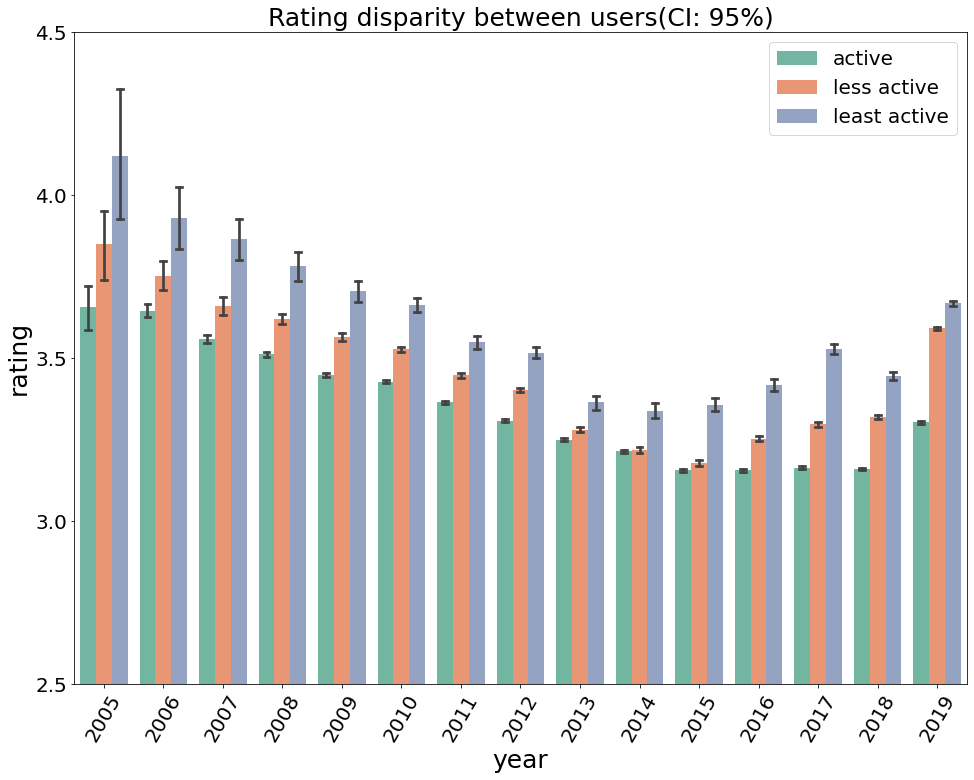

In [ ]:
# default CI: 95%
fig, ax = plt.subplots()
fig.set_size_inches(16, 12)
sns.barplot(x="year",y="rating",
            data=comments_user[comments_user['rating'].isin([1.0, 2.0, 3.0, 4.0, 5.0])],
            hue="active_state",
            hue_order=['active', 'less active', 'least active'],
            ci=95,
            capsize=.1,
            palette="Set2")
plt.title("Rating disparity between users(CI: 95%)",fontsize=25)
ax.set_yticks([2.5, 3.0, 3.5, 4.0, 4.5]);
plt.ylim([2.5, 4.5])
plt.ylabel('rating',fontsize=25)
plt.xlabel('year',fontsize=25)

plt.xticks(rotation=60, fontsize=20);
plt.yticks(fontsize=20);
plt.legend(loc = 'upper right', fontsize=20);
plt.savefig('/content/drive/MyDrive/Colab Notebooks/30200_analysis/results_rating/rating_disparity_2005_2019.png')

So we can find that as users become more active in this movie rating community, the rating they give go down, this trend hold true in all years. 

### Comparison within user-life cycle

Here we use active users' first 50% comments and last 50% comments for comparison to see if there's a increase of negativity. 

In [ ]:
# note that this dataframe has been sorted in chronological order. 
time_period = []
user_appearance_dic = {}

for _, row in tqdm(comments.iterrows()):
    if row['user_md5'] not in user_appearance_dic:
        user_appearance_dic[row['user_md5']] = 0
    user_appearance_dic[row['user_md5']] += 1
    
    if user_appearance_dic[row['user_md5']] <= int(user_dic[row['user_md5']]/2):
        time_period.append('first stage')
    else:
        time_period.append('second stage')


4428464it [06:46, 10900.62it/s]


In [ ]:
comments_user['stage'] = time_period

In [ ]:
rating_set = set((1.0, 2.0, 3.0, 4.0, 5.0))

In [ ]:
active_mask = (comments_user['active_state'] == 'active')
user_score = {}
for _, row in tqdm(comments_user[active_mask].iterrows()):
    if row['user_md5'] not in user_score:
        user_score[row['user_md5']] = [[], []]
    
    if row['stage'] == 'first stage':
        if row['rating'] in rating_set:
            user_score[row['user_md5']][0].append(row['rating']) 
    if row['stage'] == 'second stage':
        if row['rating'] in rating_set:
            user_score[row['user_md5']][1].append(row['rating']) 


2709865it [04:21, 10354.42it/s]


In [ ]:
user_score_diff = {}
count = 0
for user, score_lst in tqdm(user_score.items()):
    try: 
        user_score_diff[user] = sum(score_lst[0])/len(score_lst[0]) - sum(score_lst[1])/len(score_lst[1])
    except:
        count +=1
        
"%i active users didn't give ratings in the first stage or second stage"%count

100%|██████████| 32464/32464 [00:00<00:00, 167878.27it/s]


"266 active users didn't give ratings in the first stage or second stage"

In [ ]:
"Ratings in first stage is on average %.4f higher than that in second stage for all active users"%np.nanmean(np.array(list(user_score_diff.values())))

'Ratings in first stage is on average 0.0453 higher than that in second stage for all active users'

Combing with results from the histgram and change in average rating, we can know that in the group of active users, users with more comments are more negative. 

In [ ]:
avg_num_comments_be_pos = 0
be_pos_count = 0
avg_num_comments_be_neg = 0
be_neg_count = 0
for user, score_diff in tqdm(user_score_diff.items()):
    # become negative
    if score_diff > 0:
        avg_num_comments_be_neg += user_dic[user]
        be_neg_count += 1
    # become positive
    if score_diff < 0:
        avg_num_comments_be_pos += user_dic[user]
        be_pos_count += 1
avg_num_comments_be_pos /= be_pos_count
avg_num_comments_be_neg /= be_neg_count

print("%i users tend to give lower ratings in the second stage"%be_neg_count)
print("%i users tend to give higher ratings in the second stage"%be_pos_count)
print("Among acitve users:")
print("Users tend to give lower ratings in the second stage have %.3f comments in average;"%avg_num_comments_be_neg)
print("Users tend to give higher ratings in the second stage have %.3f comments in average."%avg_num_comments_be_pos)

100%|██████████| 32198/32198 [00:00<00:00, 779440.50it/s]

17418 users tend to give lower ratings in the second stage
14009 users tend to give higher ratings in the second stage
Among acitve users:
Users tend to give lower ratings in the second stage have 95.304 comments in average;
Users tend to give higher ratings in the second stage have 71.174 comments in average.


#### Regression

##### user mean rating as a function of comments  

In [ ]:
rating_set = set((1.0, 2.0, 3.0, 4.0, 5.0))

In [ ]:
active_mask = (comments_user['active_state'] == 'active')
user_score_all = {}
for _, row in tqdm(comments_user[active_mask].iterrows()):
    if row['user_md5'] not in user_score_all:
        user_score_all[row['user_md5']] = []
    
    if row['rating'] in rating_set:
        user_score_all[row['user_md5']].append(row['rating']) 


2709865it [04:04, 11097.03it/s]


In [ ]:
user_score_mean = {}
count = 0
for user, score_lst in tqdm(user_score_all.items()):
    try: 
        user_score_mean[user] = sum(score_lst)/len(score_lst)
    except:
        count +=1
        
"%i active users didn't give ratings for all their comments"%count

100%|██████████| 32464/32464 [00:00<00:00, 191138.33it/s]


"91 active users didn't give ratings for all their comments"

In [ ]:
users = []
num_comments = []
mean_scores = []

for user, score in user_score_mean.items():
    users.append(user)
    num_comments.append(user_dic[user])
    mean_scores.append(score)
    
dic_for_reg_mean = {'user_md5':users,
               'number_of_comments':num_comments,
               'average_rating':mean_scores}

In [ ]:
df_user_mean = pd.DataFrame(dic_for_reg_mean)

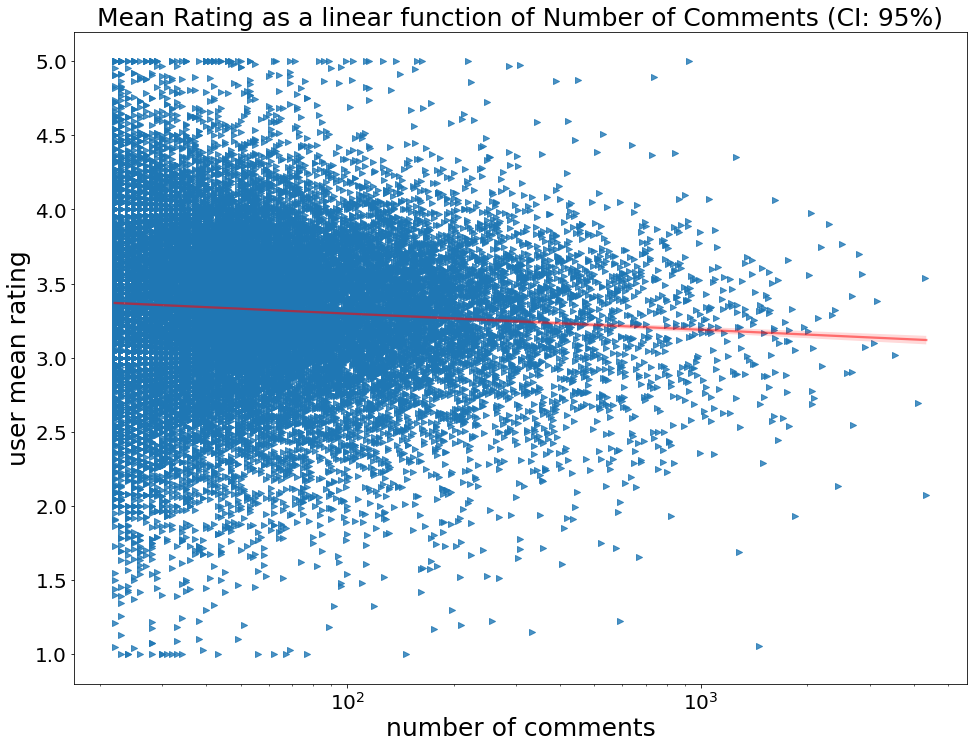

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 12)
sns.regplot(x='number_of_comments', 
            logx=True,
            y='average_rating', 
            data=df_user_mean,
            ci=95,
            fit_reg=True,
            scatter=True,
            label=True,
            line_kws={'color':'red',
                     'alpha':0.5},
            marker=">")
plt.title("Mean Rating as a linear function of Number of Comments (CI: 95%)", fontsize=25)
plt.xscale('log')

plt.ylabel('user mean rating',fontsize=25)
plt.xlabel('number of comments',fontsize=25)
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);

# plt.savefig('results/regression_of_rating_change.png')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/30200_analysis/results_rating/regression_of_rating_mean_active.png')

In [ ]:
X = np.log(np.array(df_user_mean['number_of_comments'])).reshape(-1,1)
df_user_mean['log comments'] = X
est = sm.OLS(endog=df_user_mean['average_rating'], exog=sm.add_constant(df_user_mean['log comments'])).fit()

stargazer = Stargazer([est])
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)
stargazer.show_confidence_intervals(True)
stargazer.show_degrees_of_freedom(False)
print(stargazer.render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{1}{c}{\textit{Dependent variable:}} \
\cr \cline{1-2}
\hline \\[-1.8ex]
 const & 3.516$^{***}$ \\
  & (3.487 , 3.544) \\
 log comments & -0.047$^{***}$ \\
  & (-0.054 , -0.040) \\
\hline \\[-1.8ex]
 Observations & 32,373 \\
 $R^2$ & 0.005 \\
 Adjusted $R^2$ & 0.005 \\
 Residual Std. Error & 0.516  \\
 F Statistic & 169.665$^{***}$  \\
\hline
\hline \\[-1.8ex]
\textit{Note:} & \multicolumn{1}{r}{$^{*}$p$<$0.1; $^{**}$p$<$0.05; $^{***}$p$<$0.01} \\
\end{tabular}
\end{table}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


##### user rating change as a function of comments

In [ ]:
users = []
num_comments = []
score_change = []

for user, score in user_score_diff.items():
    users.append(user)
    num_comments.append(user_dic[user])
    score_change.append(score)
    
dic_for_reg = {'user_md5':users,
               'number_of_comments':num_comments,
               'rating_change':score_change}

In [ ]:
df_user_change = pd.DataFrame(dic_for_reg)

In [ ]:
df_user_change['rating_change'] = - df_user_change['rating_change']

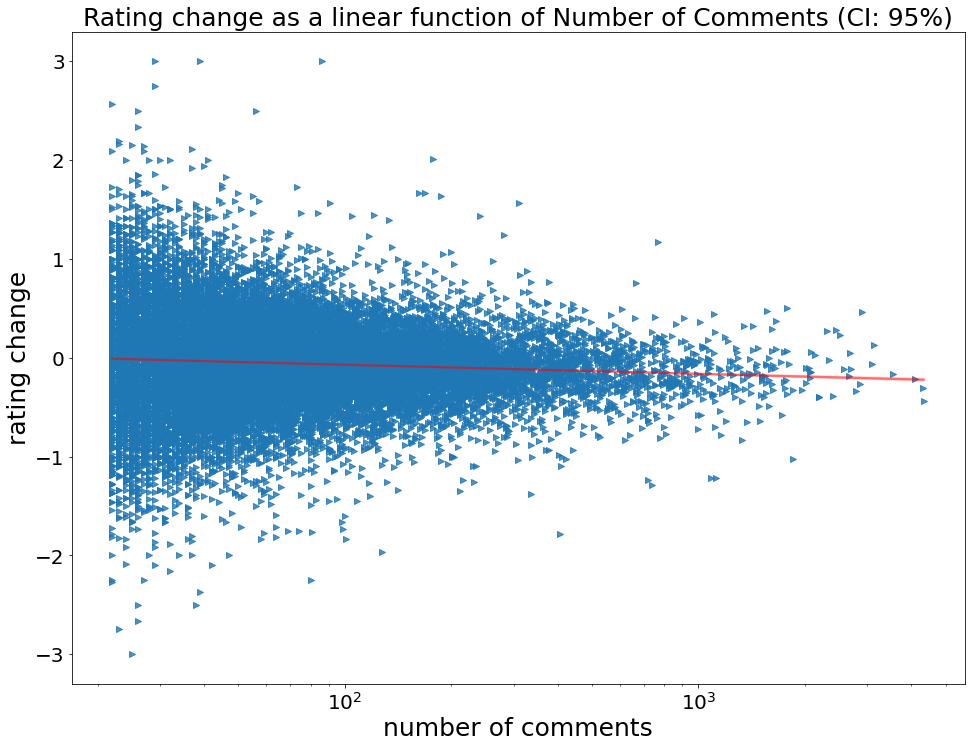

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 12)
sns.regplot(x='number_of_comments', 
            logx=True,
            y='rating_change', 
            data=df_user_change,
            ci=95,
            fit_reg=True,
            scatter=True,
            label=True,
            line_kws={'color':'red',
                     'alpha':0.5},
            marker=">")
plt.title("Rating change as a linear function of Number of Comments (CI: 95%)",fontsize=25)
plt.xscale('log')

plt.ylabel('rating change',fontsize=25)
plt.xlabel('number of comments',fontsize=25)
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);

# plt.savefig('results/regression_of_rating_change.png')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/30200_analysis/results_rating/regression_of_rating_change.png')

In [ ]:
X = np.log(np.array(df_user_change['number_of_comments'])).reshape(-1,1)

In [ ]:
df_user_change['log comments'] = X
df_user_change

,user_md5,number_of_comments,rating_change,log comments
0,4d69f002306f819034976e3818a84908,320,-0.284379,5.768321
1,6c0f657ba0d8600e45f323e65a8de516,30,-0.066667,3.401197
2,17739145eb2c9f82586e72225de046a3,62,0.033333,4.127134
3,88ade831007b8f94deb739d335f4a5d0,95,0.044770,4.553877
4,6e8a7940a8a008cefa3b34dedeeaa5d6,162,-0.135802,5.087596
...,...,...,...,...
32193,5907f83106b8215d7456f45a4302582e,95,-0.097518,4.553877
32194,700192854e25b9c3b8dc023b5c73e6e4,28,-0.500000,3.332205
32195,f59242d98372c4c99de257ecd036f5a3,31,-0.237500,3.433987
32196,eea631d69582e631d35628b2bd27dd30,32,-0.500000,3.465736


In [ ]:
est = sm.OLS(endog=df_user_change['rating_change'], exog=sm.add_constant(df_user_change['log comments'])).fit()

stargazer = Stargazer([est])
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)
stargazer.show_confidence_intervals(True)
stargazer.show_degrees_of_freedom(False)

In [ ]:
print(stargazer.render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{1}{c}{\textit{Dependent variable:}} \
\cr \cline{1-2}
\hline \\[-1.8ex]
 const & 0.114$^{***}$ \\
  & (0.090 , 0.138) \\
 log comments & -0.040$^{***}$ \\
  & (-0.046 , -0.034) \\
\hline \\[-1.8ex]
 Observations & 32,198 \\
 $R^2$ & 0.005 \\
 Adjusted $R^2$ & 0.005 \\
 Residual Std. Error & 0.435  \\
 F Statistic & 171.238$^{***}$  \\
\hline
\hline \\[-1.8ex]
\textit{Note:} & \multicolumn{1}{r}{$^{*}$p$<$0.1; $^{**}$p$<$0.05; $^{***}$p$<$0.01} \\
\end{tabular}
\end{table}


##### Rating polarization for all users

In [ ]:
comments_user

,comment_id,movie_id,user_md5,content,votes,rating,movie_year_info,year,active_state,stage
comment_time,,,,,,,,,,
2005-06-12 02:22:07,3942,1291856,4d69f002306f819034976e3818a84908,http://www.bighead.cn/?p=15,19,4.0,2003.0,2005,active,first stage
2005-06-12 02:22:07,3944,1291581,4d69f002306f819034976e3818a84908,平安夜跟小白看了粤语版，驴子的台词再创造得很可爱。,6,4.0,2001.0,2005,active,first stage
2005-06-12 02:22:07,3943,1291832,4d69f002306f819034976e3818a84908,我爱特拉沃塔的舞。,1590,5.0,1994.0,2005,active,first stage
2005-06-12 02:22:07,3945,1291582,4d69f002306f819034976e3818a84908,20061118跟小白重看了一遍。,0,5.0,2004.0,2005,active,first stage
2005-06-12 02:22:09,4104,1292210,6c0f657ba0d8600e45f323e65a8de516,重看依然很喜欢很喜欢,0,4.0,1970.0,2005,active,first stage
...,...,...,...,...,...,...,...,...,...,...
2019-09-07 15:57:07,1942942072,27063867,79a5045cc0cce798c046b84a56578d6d,就很尬，很无聊，笑点好无语，朱亚文为什么要接这样的片子啊………,0,2.0,2019.0,2019,less active,second stage
2019-09-07 15:58:03,1942943180,27063867,fed2dab59d6797ad2c3838091a1288b8,吃了感冒药去看的，困上加困。朱亚文是想通过这部作品来拓宽戏路吗？,0,2.0,2019.0,2019,less active,second stage
2019-09-07 15:58:51,1942944164,27063867,32b9368b0d6edac78eed1049434f765b,有些地方还是很好笑的，奔着两位主演去看，他们也确实有范儿，倒数第二场戏，两人穿礼服去办公室真...,0,2.0,2019.0,2019,active,second stage


In [ ]:
user_polar_all = {}
for _, row in tqdm(comments_user.iterrows()):
    if row['user_md5'] not in user_polar_all:
        # all counts, positive, neutral and negative
        user_polar_all[row['user_md5']] = [user_dic[row['user_md5']], 0, 0, 0]
    
    if row['rating'] == 4.0 or row['rating'] == 5.0:
        user_polar_all[row['user_md5']][1] += 1 
    elif row['rating'] == 3.0:
        user_polar_all[row['user_md5']][2] += 1
    elif row['rating'] == 1.0 or row['rating'] == 2.0:
        user_polar_all[row['user_md5']][3] += 1  

4428464it [06:46, 10907.35it/s]


In [ ]:
users = []
total = []
polar_scores = []

for user, item in user_polar_all.items():
    users.append(user)
    total.append(item[0])
    polar_score = (item[0] - 2*item[3] - item[2])*(item[0] - item[2])/(item[0] ** 2)
    polar_scores.append(polar_score)
    
dic_for_reg_polar_all = {'user_md5':users,
                         'number_of_comments':total,
                         'user_rating_polarization':polar_scores}
df_user_polar_all = pd.DataFrame(dic_for_reg_polar_all)

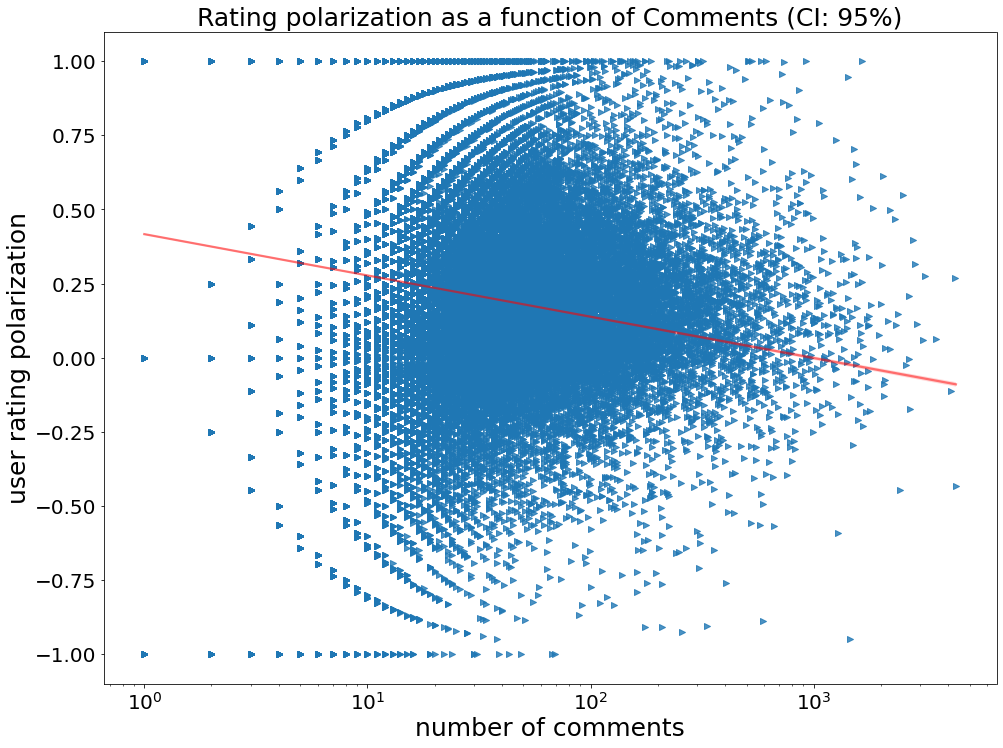

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 12)
sns.regplot(x='number_of_comments', 
            logx=True,
            y='user_rating_polarization', 
            data=df_user_polar_all,
            ci=95,
            fit_reg=True,
            scatter=True,
            label=True,
            line_kws={'color':'red',
                     'alpha':0.5},
            marker=">")
plt.title("Rating polarization as a function of Comments (CI: 95%)", fontsize=25)
plt.xscale('log')

plt.ylabel('user rating polarization',fontsize=25)
plt.xlabel('number of comments',fontsize=25)
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);

plt.savefig('/content/drive/MyDrive/Colab Notebooks/30200_analysis/results_rating/regression_of_rating_polarization_all.png')

In [ ]:
X = np.log(np.array(df_user_polar_all['number_of_comments'])).reshape(-1,1)
df_user_polar_all['log comments'] = X
est = sm.OLS(endog=df_user_polar_all['user_rating_polarization'], exog=sm.add_constant(df_user_polar_all['log comments'])).fit()

stargazer = Stargazer([est])
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)
stargazer.show_confidence_intervals(True)
stargazer.show_degrees_of_freedom(False)
print(stargazer.render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{1}{c}{\textit{Dependent variable:}} \
\cr \cline{1-2}
\hline \\[-1.8ex]
 const & 0.417$^{***}$ \\
  & (0.415 , 0.419) \\
 log comments & -0.060$^{***}$ \\
  & (-0.062 , -0.059) \\
\hline \\[-1.8ex]
 Observations & 638,961 \\
 $R^2$ & 0.010 \\
 Adjusted $R^2$ & 0.010 \\
 Residual Std. Error & 0.658  \\
 F Statistic & 6528.442$^{***}$  \\
\hline
\hline \\[-1.8ex]
\textit{Note:} & \multicolumn{1}{r}{$^{*}$p$<$0.1; $^{**}$p$<$0.05; $^{***}$p$<$0.01} \\
\end{tabular}
\end{table}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


##### Rating polarization for active users

In [ ]:
active_mask = (comments_user['active_state'] == 'active')
user_polar = {}
for _, row in tqdm(comments_user[active_mask].iterrows()):
    if row['user_md5'] not in user_polar:
        # all counts, positive, neutral and negative
        user_polar[row['user_md5']] = [user_dic[row['user_md5']], 0, 0, 0]
    
    if row['rating'] == 4.0 or row['rating'] == 5.0:
        user_polar[row['user_md5']][1] += 1 
    elif row['rating'] == 3.0:
        user_polar[row['user_md5']][2] += 1
    elif row['rating'] == 1.0 or row['rating'] == 2.0:
        user_polar[row['user_md5']][3] += 1  


users = []
total = []
polar_scores = []

for user, item in user_polar.items():
    users.append(user)
    total.append(item[0])
    polar_score = (item[0] - 2*item[3] - item[2])*(item[0] - item[2])/(item[0] ** 2)
    polar_scores.append(polar_score)
    
dic_for_reg_polar = {'user_md5':users,
                     'number_of_comments':total,
                     'user_rating_polarization':polar_scores}
df_user_polar = pd.DataFrame(dic_for_reg_polar)

2709865it [04:02, 11162.29it/s]


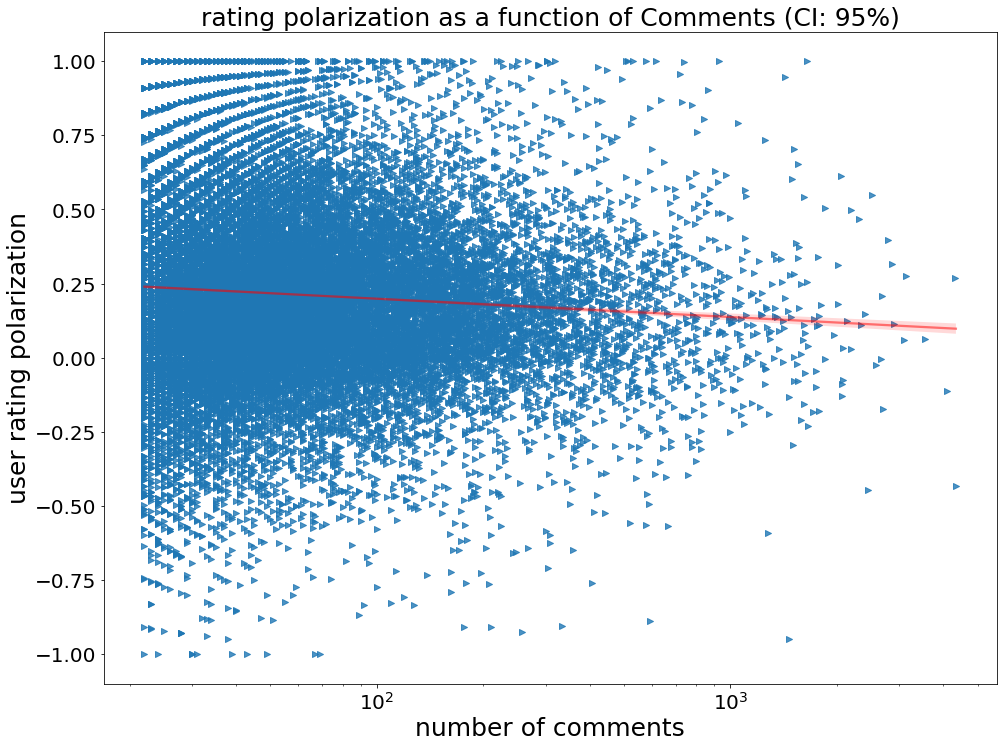

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 12)
sns.regplot(x='number_of_comments', 
            logx=True,
            y='user_rating_polarization', 
            data=df_user_polar,
            ci=95,
            fit_reg=True,
            scatter=True,
            label=True,
            line_kws={'color':'red',
                     'alpha':0.5},
            marker=">")
plt.title("rating polarization as a function of Comments (CI: 95%)", fontsize=25)
plt.xscale('log')

plt.ylabel('user rating polarization',fontsize=25)
plt.xlabel('number of comments',fontsize=25)
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);

plt.savefig('/content/drive/MyDrive/Colab Notebooks/30200_analysis/results_rating/regression_of_rating_polarization_active.png')

In [ ]:
X = np.log(np.array(df_user_polar['number_of_comments'])).reshape(-1,1)
df_user_polar['log comments'] = X
est = sm.OLS(endog=df_user_polar['user_rating_polarization'], exog=sm.add_constant(df_user_polar['log comments'])).fit()

stargazer = Stargazer([est])
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)
stargazer.show_confidence_intervals(True)
stargazer.show_degrees_of_freedom(False)
print(stargazer.render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{1}{c}{\textit{Dependent variable:}} \
\cr \cline{1-2}
\hline \\[-1.8ex]
 const & 0.323$^{***}$ \\
  & (0.307 , 0.339) \\
 log comments & -0.027$^{***}$ \\
  & (-0.031 , -0.023) \\
\hline \\[-1.8ex]
 Observations & 32,464 \\
 $R^2$ & 0.005 \\
 Adjusted $R^2$ & 0.005 \\
 Residual Std. Error & 0.286  \\
 F Statistic & 177.501$^{***}$  \\
\hline
\hline \\[-1.8ex]
\textit{Note:} & \multicolumn{1}{r}{$^{*}$p$<$0.1; $^{**}$p$<$0.05; $^{***}$p$<$0.01} \\
\end{tabular}
\end{table}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


#### User change from first stage to second stage

In [ ]:
user_mask =(comments_user['rating'].isin([1.0, 2.0, 3.0, 4.0, 5.0])) & (comments_user['active_state'] == 'active')

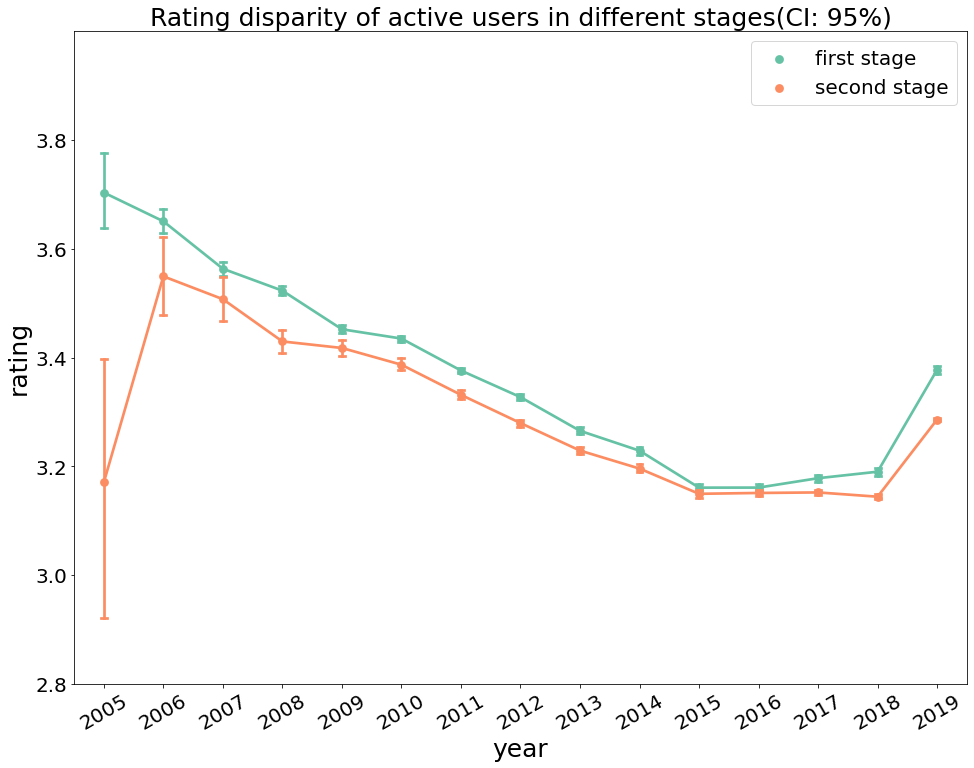

In [ ]:
# default CI: 95%
fig, ax = plt.subplots()
fig.set_size_inches(16, 12)
sns.pointplot(x="year",y="rating",
            data=comments_user[user_mask],
            ci=95,
            hue="stage",
            hue_order=['first stage', 'second stage'],
            capsize=.1,
            palette="Set2")
plt.title("Rating disparity of active users in different stages(CI: 95%)", fontsize=25)
ax.set_yticks([2.8, 3.0, 3.2, 3.4, 3.6, 3.8]);
plt.ylim([2.8, 4])

plt.ylabel('rating',fontsize=25)
plt.xlabel('year',fontsize=25)
plt.xticks(rotation=30, fontsize=20);
plt.yticks(fontsize=20);

plt.legend(loc = 'upper right',fontsize=20);
plt.savefig('/content/drive/MyDrive/Colab Notebooks/30200_analysis/results_rating/user_difference_stage_change_2005_2019.png')

Though the difference is not significant, but we did find the pattern that active users tend to give more negative comments in the second stage than in the first stage. 

Under the hood of average results may hide intersing subgroup patterns. So let's visualize the rating distribution in first stage and second stage. 

In [ ]:
fisrt_stage_mask = (comments_user['active_state'] == 'active') & (comments_user['stage'] == 'first stage')
second_stage_mask = (comments_user['active_state'] == 'active') & (comments_user['stage'] == 'second stage')

In [ ]:
comments_user_count_first = comments_user[fisrt_stage_mask]['content'].groupby(comments_user[fisrt_stage_mask].index.year).count().tolist()                     
dic_user_first, _ = get_rating_by_year(comments_user[fisrt_stage_mask], comments_user_count_first)
df_user_first = pd.DataFrame(dic_user_first, index = ['rating=1.0','rating=2.0', 'rating=3.0', 'rating=4.0', 'rating=5.0', 'rating=NaN',
                               'portion_1.0','portion_2.0', 'portion_3.0', 'portion_4.0', 'portion_5.0', 'portion_NaN',
                               'rating_mean', 'rating_std', 'user_num', 'user_avg_comments', 'user_std_comments'])
x = df_user_first.columns

1002it [00:00, 387202.19it/s]
9672it [00:00, 393708.29it/s]
23516it [00:00, 386900.24it/s]
59319it [00:00, 378418.62it/s]
85455it [00:00, 379221.51it/s]
145345it [00:00, 372207.69it/s]
179113it [00:00, 366303.66it/s]
141344it [00:00, 369871.76it/s]
111895it [00:00, 373205.84it/s]
96391it [00:00, 373896.15it/s]
94281it [00:00, 377726.30it/s]
102581it [00:00, 370165.46it/s]
123033it [00:00, 395800.38it/s]
106363it [00:00, 408514.95it/s]
67693it [00:00, 398876.98it/s]


In [ ]:
comments_user_count_second = comments_user[second_stage_mask]['content'].groupby(comments_user[second_stage_mask].index.year).count().tolist()                     
dic_user_second, _ = get_rating_by_year(comments_user[second_stage_mask], comments_user_count_second)
df_user_second = pd.DataFrame(dic_user_second, index = ['rating=1.0','rating=2.0', 'rating=3.0', 'rating=4.0', 'rating=5.0', 'rating=NaN',
                               'portion_1.0','portion_2.0', 'portion_3.0', 'portion_4.0', 'portion_5.0', 'portion_NaN',
                               'rating_mean', 'rating_std', 'user_num', 'user_avg_comments', 'user_std_comments'])

112it [00:00, 309869.42it/s]
736it [00:00, 407794.95it/s]
2515it [00:00, 405484.32it/s]
8902it [00:00, 417745.71it/s]
16845it [00:00, 384462.46it/s]
33581it [00:00, 395226.72it/s]
70034it [00:00, 390559.74it/s]
105636it [00:00, 394440.86it/s]
96936it [00:00, 391044.42it/s]
85469it [00:00, 378649.46it/s]
86001it [00:00, 374990.61it/s]
122024it [00:00, 385303.05it/s]
170728it [00:00, 386821.72it/s]
232272it [00:00, 368706.86it/s]
331071it [00:00, 368620.36it/s]


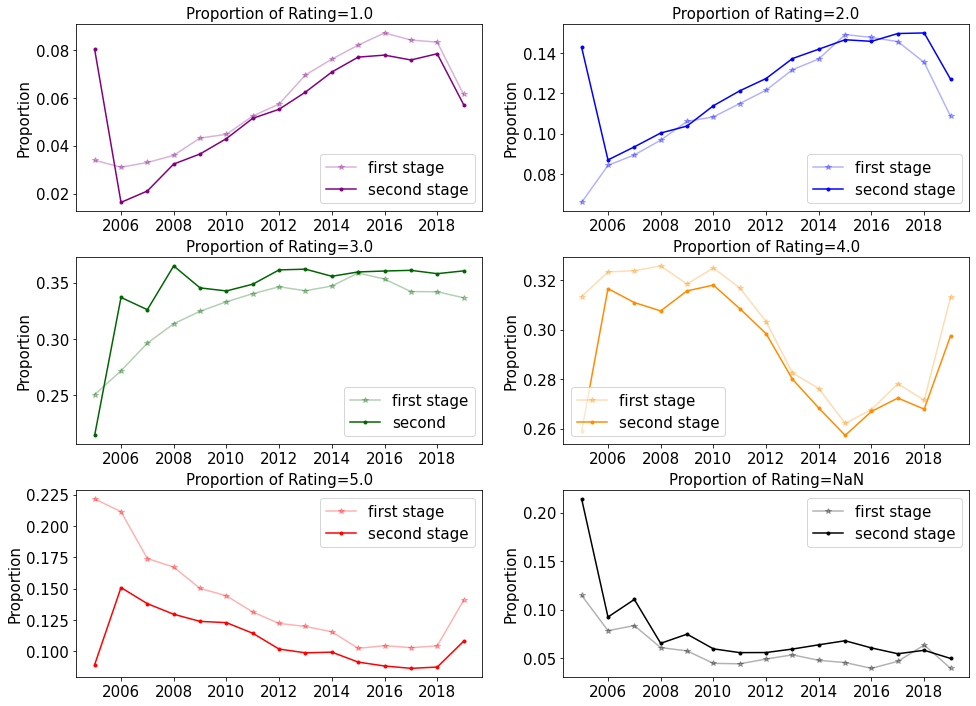

In [ ]:
fig, axes = plt.subplots(3,2)
plt.subplots_adjust(hspace=0.25)
fig.set_size_inches(16, 12)

axes[0][0].plot(x, df_user_first.loc['portion_1.0', :],
        color='purple', label='first stage', marker='*', alpha=0.3)
axes[0][0].plot(x, df_user_second.loc['portion_1.0', :],
        color='purple', label='second stage', marker='.')
axes[0][0].set_title("Proportion of Rating=1.0",fontsize=15)
axes[0][0].set_ylabel('Proportion',fontsize=15)
axes[0][0].tick_params(labelsize=15)
axes[0][0].legend(fontsize=15)


axes[0][1].plot(x, df_user_first.loc['portion_2.0', :],
        color='blue', label='first stage', marker='*', alpha=0.3)
axes[0][1].plot(x, df_user_second.loc['portion_2.0', :],
        color='blue', label='second stage', marker='.')
axes[0][1].set_title("Proportion of Rating=2.0",fontsize=15)
axes[0][1].set_ylabel('Proportion',fontsize=15)
axes[0][1].tick_params(labelsize=15)
axes[0][1].legend(fontsize=15)

axes[1][0].plot(x, df_user_first.loc['portion_3.0', :],
        color='darkgreen', label='first stage', marker='*', alpha=0.3)
axes[1][0].plot(x, df_user_second.loc['portion_3.0', :],
        color='darkgreen', label='second', marker='.')
axes[1][0].set_title("Proportion of Rating=3.0",fontsize=15)
axes[1][0].set_ylabel('Proportion',fontsize=15)
axes[1][0].tick_params(labelsize=15)
axes[1][0].legend(fontsize=15)


axes[1][1].plot(x, df_user_first.loc['portion_4.0', :],
        color='darkorange', label='first stage', marker='*', alpha=0.3)
axes[1][1].plot(x, df_user_second.loc['portion_4.0', :],
        color='darkorange', label='second stage', marker='.')
axes[1][1].set_title("Proportion of Rating=4.0",fontsize=15)
axes[1][1].set_ylabel('Proportion',fontsize=15)
axes[1][1].tick_params(labelsize=15)
axes[1][1].legend(fontsize=15, loc='lower left')

axes[2][0].plot(x, df_user_first.loc['portion_5.0', :],
        color='red', label='first stage', marker='*', alpha=0.3)
axes[2][0].plot(x, df_user_second.loc['portion_5.0', :],
        color='red', label='second stage', marker='.')
axes[2][0].set_title("Proportion of Rating=5.0",fontsize=15)
axes[2][0].set_ylabel('Proportion',fontsize=15)
axes[2][0].tick_params(labelsize=15)
axes[2][0].legend(fontsize=15)


axes[2][1].plot(x, df_user_first.loc['portion_NaN', :],
        color='k', label='first stage', marker='*', alpha=0.3)
axes[2][1].plot(x, df_user_second.loc['portion_NaN', :],
        color='k', label='second stage', marker='.')
axes[2][1].set_title("Proportion of Rating=NaN",fontsize=15)
axes[2][1].set_ylabel('Proportion',fontsize=15)
axes[2][1].tick_params(labelsize=15)
axes[2][1].legend(fontsize=15)

plt.savefig('/content/drive/MyDrive/Colab Notebooks/30200_analysis/results_rating/rating_proprotion_between_stages.png')

We use dark colors to denote ratings in first stage and light colors to denote ratings in second stage. We can find that users in their first stage would give higher proprotion of high ratings but lower proportion of medim ratings and NaN ratings, which further confirm our hypothesis. As users spend more time in this community, they tend give less positive ratings. (Plan: And using BERT we'd show that though a rating=3.0 sometimes could be positive, but it's more likely to be negative. So users were actually shifting to negative side)

### Check confounder: Movie rating as a function of comments 

This part aims at excluding the expolartion & exploitation effect. 

In [ ]:
movie_rating_dic = {}
for idx, row in tqdm(comments_user.iterrows()):
  if row['movie_id'] not in movie_rating_dic:
    movie_rating_dic[row['movie_id']] = []
  movie_rating_dic[row['movie_id']].append(row['rating']) 

4428464it [06:03, 12198.45it/s]


In [ ]:
movie_avg_rating = {}
for movie, rating_lst in movie_rating_dic.items():
  movie_avg_rating[movie] = np.nanmean(rating_lst)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
comments_user

,comment_id,movie_id,user_md5,content,votes,rating,movie_year_info,year,active_state,stage
comment_time,,,,,,,,,,
2005-06-12 02:22:07,3942,1291856,4d69f002306f819034976e3818a84908,http://www.bighead.cn/?p=15,19,4.0,2003.0,2005,active,first stage
2005-06-12 02:22:07,3944,1291581,4d69f002306f819034976e3818a84908,平安夜跟小白看了粤语版，驴子的台词再创造得很可爱。,6,4.0,2001.0,2005,active,first stage
2005-06-12 02:22:07,3943,1291832,4d69f002306f819034976e3818a84908,我爱特拉沃塔的舞。,1590,5.0,1994.0,2005,active,first stage
2005-06-12 02:22:07,3945,1291582,4d69f002306f819034976e3818a84908,20061118跟小白重看了一遍。,0,5.0,2004.0,2005,active,first stage
2005-06-12 02:22:09,4104,1292210,6c0f657ba0d8600e45f323e65a8de516,重看依然很喜欢很喜欢,0,4.0,1970.0,2005,active,first stage
...,...,...,...,...,...,...,...,...,...,...
2019-09-07 15:57:07,1942942072,27063867,79a5045cc0cce798c046b84a56578d6d,就很尬，很无聊，笑点好无语，朱亚文为什么要接这样的片子啊………,0,2.0,2019.0,2019,less active,second stage
2019-09-07 15:58:03,1942943180,27063867,fed2dab59d6797ad2c3838091a1288b8,吃了感冒药去看的，困上加困。朱亚文是想通过这部作品来拓宽戏路吗？,0,2.0,2019.0,2019,less active,second stage
2019-09-07 15:58:51,1942944164,27063867,32b9368b0d6edac78eed1049434f765b,有些地方还是很好笑的，奔着两位主演去看，他们也确实有范儿，倒数第二场戏，两人穿礼服去办公室真...,0,2.0,2019.0,2019,active,second stage


In [ ]:
user_movie_sequence = {}
for _, row in tqdm(comments_user.iterrows()):
    if row['user_md5'] not in user_movie_sequence:
        user_movie_sequence[row['user_md5']] = {}

    user_movie_sequence[row['user_md5']][row['movie_id']]=len(user_movie_sequence[row['user_md5']]) + 1 

4428464it [06:34, 11225.70it/s]


In [ ]:
watch_sequence = []
movie_rating_lst = []

for _, row in tqdm(comments_user.iterrows()):
  sequence = user_movie_sequence[row['user_md5']][row['movie_id']]
  watch_sequence.append(sequence)
  movie_rating_lst.append(movie_avg_rating[row['movie_id']])

4428464it [06:14, 11820.95it/s]


In [ ]:
dic_for_watch_sequence_rating = {'watch_sequence':watch_sequence,
                                 'movie_rating':movie_rating_lst}
df_watch_sequence_rating = pd.DataFrame(dic_for_watch_sequence_rating)
nan_rating_mask = df_watch_sequence_rating['movie_rating'].isnull()

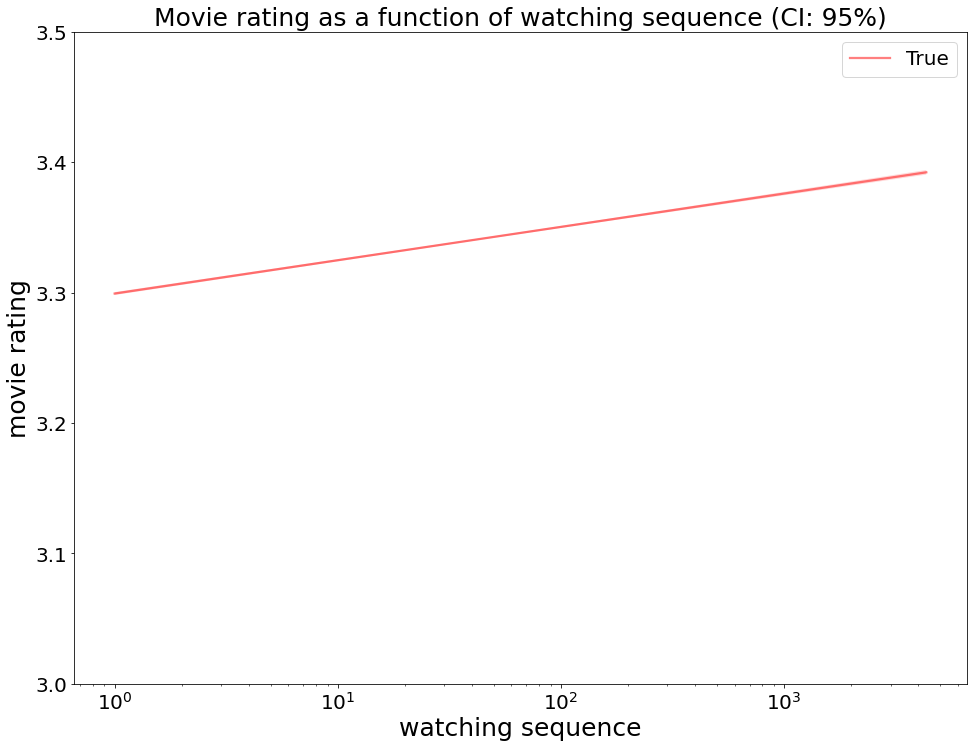

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 12)
sns.regplot(x='watch_sequence', 
            logx=True,
            y='movie_rating', 
            data=df_watch_sequence_rating[~nan_rating_mask],
            ci=95,
            fit_reg=True,
            scatter=False,
            label=True,
            line_kws={'color':'red',
                     'alpha':0.5},
            marker=">")
plt.title("Movie rating as a function of watching sequence (CI: 95%)",fontsize=25)
plt.xscale('log')
ax.set_yticks([3.0, 3.1, 3.2, 3.3, 3.4, 3.5]);

plt.ylabel('movie rating',fontsize=25)
plt.xlabel('watching sequence',fontsize=25)
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);

plt.legend(loc='upper right',fontsize=20)

plt.savefig('/content/drive/MyDrive/Colab Notebooks/30200_analysis/results_rating/regression_of_movie_rating_watch_sequence_no_scatter.png')

In [ ]:
df_no_nan_all = df_watch_sequence_rating[~nan_rating_mask]

In [ ]:
X = np.log(np.array(df_no_nan_all['watch_sequence'])).reshape(-1,1)
df_no_nan_all['log sequence'] = X
est = sm.OLS(endog=df_no_nan_all['movie_rating'], exog=sm.add_constant(df_no_nan_all['log sequence'])).fit()

stargazer = Stargazer([est])
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)
stargazer.show_confidence_intervals(True)
stargazer.show_degrees_of_freedom(False)
print(stargazer.render_latex())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{1}{c}{\textit{Dependent variable:}} \
\cr \cline{1-2}
\hline \\[-1.8ex]
 const & 3.299$^{***}$ \\
  & (3.298 , 3.300) \\
 log sequence & 0.011$^{***}$ \\
  & (0.011 , 0.011) \\
\hline \\[-1.8ex]
 Observations & 4,427,566 \\
 $R^2$ & 0.001 \\
 Adjusted $R^2$ & 0.001 \\
 Residual Std. Error & 0.679  \\
 F Statistic & 4739.476$^{***}$  \\
\hline
\hline \\[-1.8ex]
\textit{Note:} & \multicolumn{1}{r}{$^{*}$p$<$0.1; $^{**}$p$<$0.05; $^{***}$p$<$0.01} \\
\end{tabular}
\end{table}


For active users

In [ ]:
nan_rating_mask = df_watch_sequence_rating['movie_rating'].isnull()
active_mask = df_watch_sequence_rating['watch_sequence'] >= threshold_comments

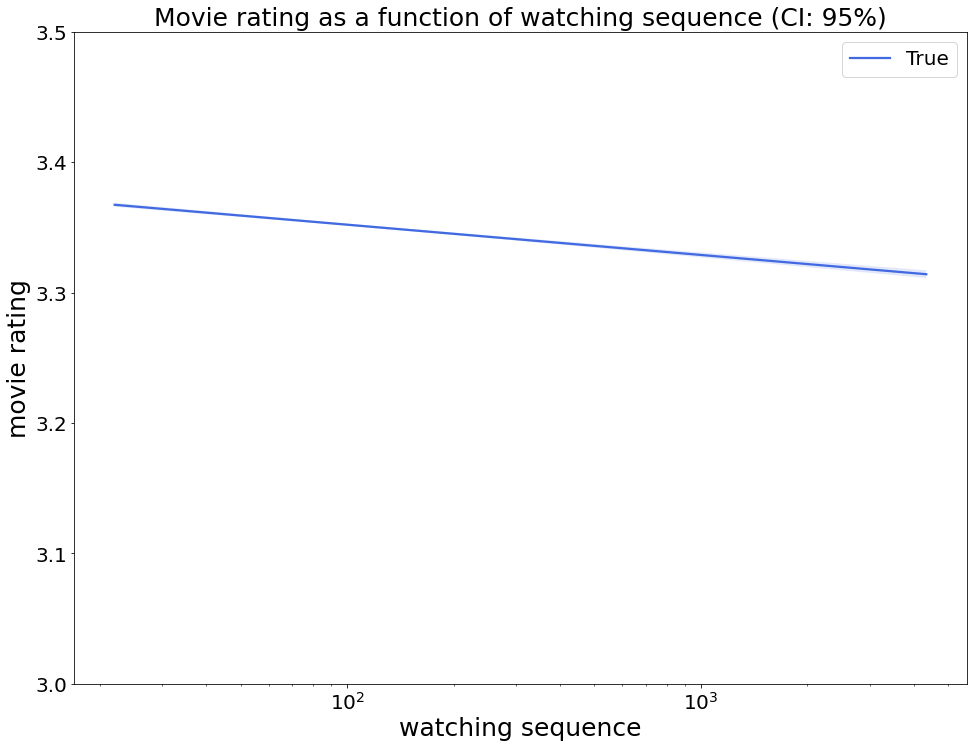

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 12)
sns.regplot(x='watch_sequence', 
            logx=True,
            y='movie_rating', 
            data=df_watch_sequence_rating[(~nan_rating_mask) & active_mask],
            ci=95,
            fit_reg=True,
            scatter=False,
            label=True,
            line_kws={'color':'royalblue'},
            marker=">")
plt.title("Movie rating as a function of watching sequence (CI: 95%)", fontsize=25)
plt.xscale('log')
ax.set_yticks([3.0, 3.1, 3.2, 3.3, 3.4, 3.5]);

plt.ylabel('movie rating',fontsize=25)
plt.xlabel('watching sequence',fontsize=25)
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);

plt.legend(loc='upper right',fontsize=20)

plt.savefig('/content/drive/MyDrive/Colab Notebooks/30200_analysis/results_rating/regression_of_movie_rating_watch_sequence_active_users_no_scatter.png')

In [ ]:
df_no_nan_active = df_watch_sequence_rating[(~nan_rating_mask) & active_mask]

In [ ]:
X = np.log(np.array(df_no_nan_active['watch_sequence'])).reshape(-1,1)
df_no_nan_active['log sequence'] = X
est = sm.OLS(endog=df_no_nan_active['movie_rating'], exog=sm.add_constant(df_no_nan_active['log sequence'])).fit()

stargazer = Stargazer([est])
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)
stargazer.show_confidence_intervals(True)
stargazer.show_degrees_of_freedom(False)
print(stargazer.render_latex())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{1}{c}{\textit{Dependent variable:}} \
\cr \cline{1-2}
\hline \\[-1.8ex]
 const & 3.398$^{***}$ \\
  & (3.395 , 3.402) \\
 log sequence & -0.010$^{***}$ \\
  & (-0.011 , -0.009) \\
\hline \\[-1.8ex]
 Observations & 2,027,477 \\
 $R^2$ & 0.000 \\
 Adjusted $R^2$ & 0.000 \\
 Residual Std. Error & 0.643  \\
 F Statistic & 634.430$^{***}$  \\
\hline
\hline \\[-1.8ex]
\textit{Note:} & \multicolumn{1}{r}{$^{*}$p$<$0.1; $^{**}$p$<$0.05; $^{***}$p$<$0.01} \\
\end{tabular}
\end{table}


## Comparision between popular and less popular movies

Note that we only have 220 comments for popular movies, there's a risk of being confounded by ranking algorithms, so  we need to check that if there's a systematic difference between popular movies and less popular movies in terms of distribution of raitng of movie comments.

Some movies have more than 220 comments, because the researchers scraped the webstie many times(durting the scraping interval the list of viewable comments for unlogged users are changed) and merged those comments 

In [ ]:
movie_dic = {}
for idx, row in tqdm(comments.iterrows()):
    if row['movie_id'] not in movie_dic:
        movie_dic[row['movie_id']] = 0
    movie_dic[row['movie_id']] += 1

4428464it [04:03, 18179.73it/s]


In [ ]:
len(movie_dic.keys())

68887

In [ ]:
popular_movies = 0
comments_from_popular = 0
for v in tqdm(movie_dic.values()):
    if v >=220:
        popular_movies +=1
        comments_from_popular += v

"%i popular movies"%popular_movies, '%i comments from popular movies'%comments_from_popular

100%|██████████| 68887/68887 [00:00<00:00, 2260927.90it/s]


('6491 popular movies', '1662569 comments from popular movies')

In [ ]:
movie_popularity = []
for idx, row in tqdm(comments.iterrows()):
    if movie_dic[row['movie_id']] >= 220:
        movie_popularity.append('popular')
    else:
        movie_popularity.append('less popular')

4428464it [03:44, 19723.64it/s]


In [ ]:
comments_movie = pd.concat([comments, 
                            pd.DataFrame({'popularity':movie_popularity},
                                         index=comments.index)], axis=1)

In [ ]:
comments_movie['year'] = comments.index.year
comments_movie

,comment_id,movie_id,user_md5,content,votes,rating,popularity,year
comment_time,,,,,,,,
2005-06-12 02:22:07,3942,1291856,4d69f002306f819034976e3818a84908,http://www.bighead.cn/?p=15,19,4.0,popular,2005
2005-06-12 02:22:07,3944,1291581,4d69f002306f819034976e3818a84908,平安夜跟小白看了粤语版，驴子的台词再创造得很可爱。,6,4.0,less popular,2005
2005-06-12 02:22:07,3943,1291832,4d69f002306f819034976e3818a84908,我爱特拉沃塔的舞。,1590,5.0,less popular,2005
2005-06-12 02:22:07,3945,1291582,4d69f002306f819034976e3818a84908,20061118跟小白重看了一遍。,0,5.0,popular,2005
2005-06-12 02:22:09,4104,1292210,6c0f657ba0d8600e45f323e65a8de516,重看依然很喜欢很喜欢,0,4.0,less popular,2005
...,...,...,...,...,...,...,...,...
2019-09-07 15:57:07,1942942072,27063867,79a5045cc0cce798c046b84a56578d6d,就很尬，很无聊，笑点好无语，朱亚文为什么要接这样的片子啊………,0,2.0,less popular,2019
2019-09-07 15:58:03,1942943180,27063867,fed2dab59d6797ad2c3838091a1288b8,吃了感冒药去看的，困上加困。朱亚文是想通过这部作品来拓宽戏路吗？,0,2.0,less popular,2019
2019-09-07 15:58:51,1942944164,27063867,32b9368b0d6edac78eed1049434f765b,有些地方还是很好笑的，奔着两位主演去看，他们也确实有范儿，倒数第二场戏，两人穿礼服去办公室真...,0,2.0,less popular,2019


In [ ]:
comments_movie_plt = comments_movie.reset_index()

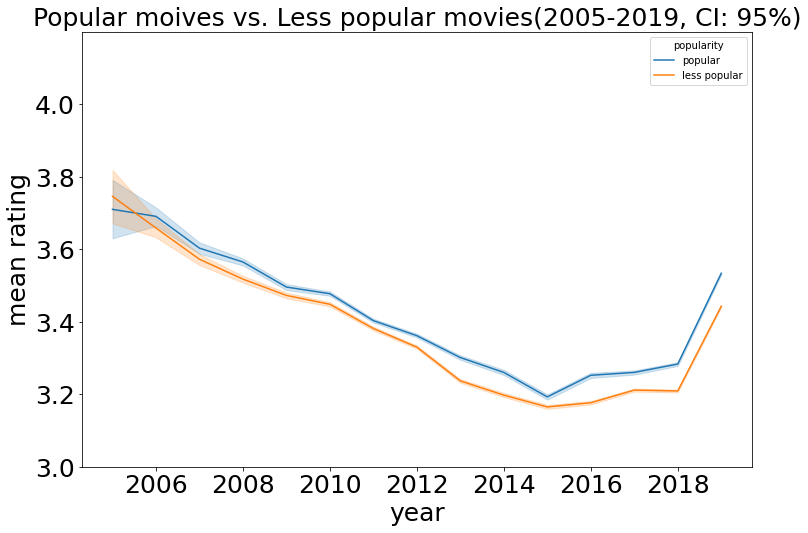

In [ ]:
# default CI: 95%
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
sns.lineplot(x="year",y="rating",
             data=comments_movie_plt[comments_movie_plt['rating'].isin([1.0, 2.0, 3.0, 4.0, 5.0])],
             hue="popularity",
             hue_order=['popular', 'less popular'],
             ci=95)
plt.title("Popular moives vs. Less popular movies(2005-2019, CI: 95%)",fontsize=25)
ax.set_yticks([3.0, 3.2, 3.4, 3.6, 3.8, 4.0]);
plt.ylim([3.0, 4.2])
plt.ylabel('mean rating',fontsize=25)
plt.xlabel('year',fontsize=25)
plt.xticks(fontsize=25);
plt.yticks(fontsize=25);

plt.savefig('/content/drive/MyDrive/Colab Notebooks/30200_analysis/results_rating/mean_rating_comparison_2005_2019.png')